In [1]:
# import necessary libraries

import torch
import numpy as np
import torch.nn.functional as F

from torch import nn, optim
from numpy import linalg as LA
from scipy.stats import rankdata
from collections import OrderedDict
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# required variables 

batch_size = 64  # batch size
valid_size = 0.2  # validation set size: 20%
epochs = 20  # number of epochs
min_valid_loss = np.Inf  # min value for validation loss
transform = transforms.ToTensor()  # necessary image transform i.e. conver tot Tensor 

In [3]:
# Download the Train and Test set

trainset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

In [4]:
# Split the training set indices into training and validation set indices using 80:20 ratio

len_trainset = len(trainset)
index_list = list(range(len_trainset))
np.random.shuffle(index_list)
split_index = int(len_trainset * valid_size)
train_indices, valid_indices = index_list[split_index:], index_list[:split_index]

In [5]:
# Create Samplers for training and validation set using the indices

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [6]:
# Create loaders for train, validation and testing set using samplers

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [7]:
# Model Architecture as descried in the given PDF


class FMNISTClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1000, bias=False)
        self.fc2 = nn.Linear(1000, 1000, bias=False)
        self.fc3 = nn.Linear(1000, 500, bias=False)
        self.fc4 = nn.Linear(500, 200, bias=False)
        self.fc5 = nn.Linear(200, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x

In [8]:
# Create model

model = FMNISTClf()
model

FMNISTClf(
  (fc1): Linear(in_features=784, out_features=1000, bias=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=False)
  (fc3): Linear(in_features=1000, out_features=500, bias=False)
  (fc4): Linear(in_features=500, out_features=200, bias=False)
  (fc5): Linear(in_features=200, out_features=10, bias=False)
)

In [9]:
# Using CrossEntropy as my Loss function and Adam Optimizer with a learning rate of 0.01 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
# Training

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    # Training
    for image, label in trainloader:
        # Set Gradients to zero
        optimizer.zero_grad()
        # forward pass the image through the network
        output = model(image)
        # Get the loss
        loss = criterion(output, label)
        # Backward propagation
        loss.backward()
        # Optimization step
        optimizer.step()
        # Train loss is the loss multiplied by the batch size
        train_loss += loss.item() * image.size(0)
    model.eval()
    # Validation
    for image, label in validloader:
        # forward pass the image through the network
        output = model(image)
        # Get the loss
        loss = criterion(output, label)
        # Validation loss is the loss multiplied by the batch size
        valid_loss += loss.item() * image.size(0)

    # Total train loss is the average of train loss, same for validation loss
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
  
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch+1, 
      train_loss,
      valid_loss
      ))
    
    # save model only if validation loss has decreased
    if valid_loss <= min_valid_loss:
        print('Validation loss decreased ({} --> {}).  Saving model ...'.format(
        min_valid_loss,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = valid_loss

Epoch: 1 	Training Loss: 0.744186 	Validation Loss: 0.479770
Validation loss decreased (inf --> 0.47976952854792276).  Saving model ...
Epoch: 2 	Training Loss: 0.508259 	Validation Loss: 0.461102
Validation loss decreased (0.47976952854792276 --> 0.4611016027927399).  Saving model ...
Epoch: 3 	Training Loss: 0.452227 	Validation Loss: 0.456838
Validation loss decreased (0.4611016027927399 --> 0.4568377684752146).  Saving model ...
Epoch: 4 	Training Loss: 0.423790 	Validation Loss: 0.418976
Validation loss decreased (0.4568377684752146 --> 0.41897608669598896).  Saving model ...
Epoch: 5 	Training Loss: 0.435070 	Validation Loss: 0.473471
Epoch: 6 	Training Loss: 0.432210 	Validation Loss: 0.441718
Epoch: 7 	Training Loss: 0.429648 	Validation Loss: 0.504991
Epoch: 8 	Training Loss: 0.406071 	Validation Loss: 0.429162
Epoch: 9 	Training Loss: 0.406297 	Validation Loss: 0.432117
Epoch: 10 	Training Loss: 0.387194 	Validation Loss: 0.425926
Epoch: 11 	Training Loss: 0.415324 	Validatio

In [11]:
# Function to check test accuracy

def test_accuracy(model, testloader, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()

    for data, target in testloader:
        # forward pass
        output = model(data)
        # Get the loss
        loss = criterion(output, target)
        # Test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class and get the max class
        _, pred = torch.max(output, 1)
        # compare prediction with true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # Overall accuracy
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    return overall_accuracy

In [12]:
# Prune ranges provided in the PDF

prune_percentage = [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]
accuracies_wp = []
accuracies_np = []

# Get the accuracy without any pruning 
initial_accuracy = test_accuracy(model, testloader, criterion)
accuracies_wp.append(initial_accuracy)
accuracies_np.append(initial_accuracy)

In [13]:
# Weight Pruning

# Loop through each prune percent
for k in prune_percentage[1:]:
    # Load the original unprunned model
    model = FMNISTClf()
    model.load_state_dict(torch.load('model.pt'))
    # Get all the weights
    weights = model.state_dict()
    # Get keys to access model weights
    layers = list(model.state_dict())
    ranks = {}
    pruned_weights = []
    # For each layer except the output one
    for l in layers[:-1]:
        # Get weights for each layer and conver to numpy 
        data = weights[l]
        w = np.array(data)
        # Rank the weights element wise and reshape rank elements as the model weights
        ranks[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)
        # Get the threshold value based on the value of k(prune percentage) 
        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)
        # Assign rank elements to 0 that are less than or equal to the threshold and 1 to those that are above.
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        # Multiply weights array with ranks to zero out the lower ranked weights
        w = w * ranks[l]
        # Assign the updated weights as tensor to data and append to the pruned_weights list 
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    # Append the last layer weights as it is
    pruned_weights.append(weights[layers[-1]])
    # Update the model weights with all the updated weights 
    new_state_dict = OrderedDict()
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
    model.state_dict = new_state_dict
    # append the test accuracy to accuracies_wp
    accuracies_wp.append(test_accuracy(model, testloader, criterion))

In [14]:
# Neuron Pruning
# Code is almost same as above so comments are provided for only different parts of code

for k in prune_percentage[1:]:
    model = FMNISTClf()
    model.load_state_dict(torch.load('model.pt'))
    weights = model.state_dict()
    layers = list(model.state_dict())
    ranks = {}
    pruned_weights = []
    for l in layers[:-1]:
        data = weights[l]
        w = np.array(data)
        # taking norm for each neuron
        norm = LA.norm(w, axis=0)
        # repeat the norm values to get the shape similar to that of layer weights
        norm = np.tile(norm, (w.shape[0],1))
        ranks[l] = (rankdata(norm, method='dense') - 1).astype(int).reshape(norm.shape)
        lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        w = w * ranks[l]
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    pruned_weights.append(weights[layers[-1]])
    new_state_dict = OrderedDict()
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
    model.state_dict = new_state_dict
    accuracies_np.append(test_accuracy(model, testloader, criterion))


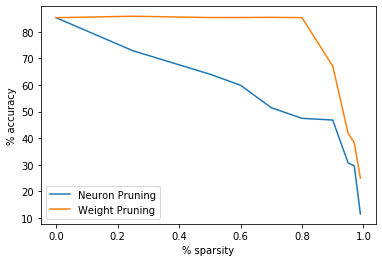

In [16]:
# Plot the sparsity vs accuracy graph

import matplotlib.pyplot as plt
plt.plot(prune_percentage, accuracies_np, label='Neuron Pruning')
plt.plot(prune_percentage, accuracies_wp, label='Weight Pruning')
plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
plt.show()